<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgSeg/UNet_VOC2012_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM




In [1]:
!pip install -q --upgrade albumentations==0.5.1

     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 952kB 25.0MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 


# Import

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [3]:
IN_HEIGHT, IN_WIDTH = 128, 128

RESOURCE = "GPU"

FOLD = "KFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Encoder(nn.Module):
    def __init__(self, dim1, dim2, stack_num=2):
        super(Encoder, self).__init__()
        
        module = []
        for i in range(stack_num):
            f = dim1 if i == 0 else dim2
            module.append(nn.Conv2d(f, dim2, kernel_size=3, padding=1, stride=1))
            module.append(nn.BatchNorm2d(dim2))
            module.append(nn.ReLU())
            
        self.module = nn.Sequential(*module)

    def forward(self, x):
        return self.module(x)

class UpConv(nn.Module):
    def __init__(self, dim1, dim2):
        super(UpConv, self).__init__()
        self.module = nn.Sequential(
            nn.ConvTranspose2d(dim1, dim2, kernel_size=2, stride=2),
            nn.BatchNorm2d(dim2)
        )

    def forward(self, x):
        return self.module(x)

    
class UNet(nn.Module):
    def __init__(self, dim=64, in_channel=3, out_channel=22):
        super(UNet, self).__init__()

        self.encoder1 = Encoder(in_channel, dim) 
        self.encoder2 = Encoder(dim, dim * 2)
        self.encoder3 = Encoder(dim * 2, dim * 4)
        self.encoder4 = Encoder(dim * 4, dim * 8)
        self.encoder5 = Encoder(dim * 8, dim * 16)

        self.upconv4 = UpConv(dim * 16, dim * 8)
        self.decoder4 = Encoder(dim * 16, dim * 8)

        self.upconv3 = UpConv(dim * 8, dim * 4)
        self.decoder3 = Encoder(dim * 8, dim * 4)

        self.upconv2 = UpConv(dim * 4, dim * 2)
        self.decoder2 = Encoder(dim * 4, dim * 2)

        self.upconv1 = UpConv(dim * 2, dim)   
        self.decoder1 = nn.Sequential(
            Encoder(dim * 2, dim),
            nn.Conv2d(dim, out_channel, kernel_size=1, padding=0, stride=1)
        )

        
    def forward(self, x):
        x_e1 = self.encoder1(x)
        x = F.max_pool2d(x_e1, 2, stride=2, padding=0)
        x_e2 = self.encoder2(x)
        x = F.max_pool2d(x_e2, 2, stride=2, padding=0)
        x_e3 = self.encoder3(x)
        x = F.max_pool2d(x_e3, 2, stride=2, padding=0)
        x_e4 = self.encoder4(x)
        x = F.max_pool2d(x_e4, 2, stride=2, padding=0)
        x = self.encoder5(x)

        x = self.upconv4(x) #F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([x, x_e4], dim=1)
        x = self.decoder4(x)

        x = self.upconv3(x) #F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([x, x_e3], dim=1)
        x = self.decoder3(x)
 
        x = self.upconv2(x) #F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([x, x_e2], dim=1)
        x = self.decoder2(x)

        x = self.upconv1(x) #F.interpolate(x, scale_factor=2, mode='nearest')
        x = torch.cat([x, x_e1], dim=1)
        x = self.decoder1(x)
        return x

In [10]:
transforms_train = A.Compose([
    # A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.ShiftScaleRotate(p=0.5),
    # A.RandomRotate90(p=0.5),
    # A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    # A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    # A.CoarseDropout(p=0.5),
    # A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])


In [6]:
class VOCDataset(Dataset):
    def __init__(self, Xs, ts, transforms=None, ignore_border=True):
        self.Xs = Xs
        self.ts = ts
        self.transforms=transforms
        self.data_num = len(Xs)
        self.ignore_border = ignore_border
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.Xs[idx]
        t = self.ts[idx]

        if self.ignore_border:
            t[t == 255] = 0

        if self.transforms:
            transformed = self.transforms(image=x, mask=t)
            x = transformed["image"]
            t = transformed["mask"]
            
        return x, t.long()

In [7]:
def show_sample(Xs, show_num=8, name="input"):
    Xs = Xs.detach().cpu().numpy().transpose(0, 2, 3, 1)
    Xs -= Xs.min()
    Xs /= Xs.max()
    Xs = (Xs * 255).astype(np.uint8)
    #Xs = (Xs * 127.5 + 127.5).astype(np.uint8)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x)
        plt.title(name)
        plt.axis('off')
        
    plt.show()

def show_sample_seg(Xs, show_num=8, name="output"):
    Xs = Xs.detach().cpu().numpy().argmax(axis=1)

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="jet", vmax=21)
        plt.title(name)
        plt.axis('off')
        
    plt.show()

def show_sample_label(Xs, show_num=8, name="label"):
    Xs = Xs.detach().cpu().numpy()

    plt.figure(figsize=(12, 1))

    for i in range(show_num):
        # show input
        x = Xs[i]
        plt.subplot(1, show_num, i + 1)
        plt.imshow(x, cmap="jet", vmax=21)
        plt.title(name)
        plt.axis('off')
        
    plt.show()

# Train

In [15]:
def train():

    ds = torchvision.datasets.VOCSegmentation(root="./", image_set="train", download=True)
    _inds = np.arange(len(ds))

    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(_inds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(_inds, _inds, _inds)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(_inds, _inds)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    EPOCH = 200
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = [np.array(ds[idx][0], dtype=np.float32) for idx in train_idx]
        X_val = [np.array(ds[idx][0], dtype=np.float32) for idx in val_idx]

        t_train = [np.array(ds[idx][1].convert('P')) for idx in train_idx]
        t_val = [np.array(ds[idx][1].convert('P')) for idx in val_idx]

        dataset_train = VOCDataset(X_train, t_train, transforms=transforms_train)
        dataset_val = VOCDataset(X_val, t_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=4, shuffle=True, pin_memory=False)
        dataloader_val = DataLoader(dataset_val, batch_size=32, num_workers=1, shuffle=False, pin_memory=False)
        
        train_n = len(X_train)
        val_n = len(X_val)
        
        #---
        # model
        #---
        model = UNet()
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ts = batch[1].to(device) # target
            
                ys = model(xs)

                _ys = ys.permute(0, 2, 3, 1).reshape(-1, 22)
                _ts = ts.view(-1)

                loss = criterion(_ys, _ts) / train_n / IN_HEIGHT / IN_WIDTH
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(ys.data, 1)
                total += ys.size(0)
                correct += (predicted == ts).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total / IN_HEIGHT / IN_WIDTH
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ts = batch[1].to(device) # target
                
                    ys = model(xs)

                    _ys = ys.permute(0, 2, 3, 1).reshape(-1, 22)
                    _ts = ts.view(-1)

                    loss = criterion(_ys, _ts)
                    val_loss += loss.item() / val_n / IN_HEIGHT / IN_WIDTH
                    
                    _, predicted = torch.max(ys.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ts).sum().item()

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total / IN_HEIGHT / IN_WIDTH
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

            if (epoch + 1) % 50 == 0:
                show_sample(xs)
                show_sample_seg(ys)
                show_sample_label(ts)

            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()

        break
        
    return train_models, train_model_paths

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
KFold fold:1/2
train_N=732, val_N=732
fold:1 epoch:1/200 [tra]loss:2.7055 acc:0.4335  [val]loss:2.6030 acc:0.0000  [time]total:17.61sec tra:12.72sec val:4.89sec
fold:1 epoch:2/200 [tra]loss:2.3474 acc:0.5365  [val]loss:3.3099 acc:0.0000  [time]total:17.22sec tra:12.46sec val:4.76sec
fold:1 epoch:3/200 [tra]loss:2.1678 acc:0.5552  [val]loss:2.1840 acc:0.0000  [time]total:16.50sec tra:11.95sec val:4.55sec
fold:1 epoch:4/200 [tra]loss:2.0460 acc:0.5677  [val]loss:2.1333 acc:0.0000  [time]total:16.35sec tra:11.80sec val:4.55sec
fold:1 epoch:5/200 [tra]loss:1.9295 acc:0.5936  [val]loss:1.9578 acc:0.0000  [time]total:16.62sec tra:11.91sec val:4.71sec
fold:1 epoch:6/200 [tra]loss:1.8223 acc:0.6411  [val]loss:1.6755 acc:0.0000  [time]total:16.77sec tra:12.08sec val:4.69sec
fold:1 epoch:7/200 [tra]loss:1.7365 acc:0.6857  [val]loss:2.5180 acc:0.0000  [time]total:16.83sec tra:12.09sec val:4.74sec
fold:1 epoch:8/200 [tra]loss:1.6463

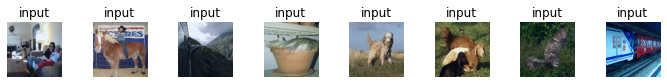

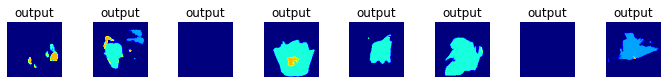

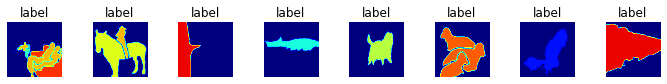

fold:1 epoch:51/200 [tra]loss:0.8299 acc:0.7762  [val]loss:0.9648 acc:0.0000  [time]total:16.84sec tra:12.15sec val:4.68sec
fold:1 epoch:52/200 [tra]loss:0.8246 acc:0.7777  [val]loss:1.0944 acc:0.0000  [time]total:16.82sec tra:12.13sec val:4.68sec
fold:1 epoch:53/200 [tra]loss:0.8194 acc:0.7761  [val]loss:0.9624 acc:0.0000  [time]total:16.80sec tra:12.14sec val:4.67sec
fold:1 epoch:54/200 [tra]loss:0.8084 acc:0.7820  [val]loss:0.9783 acc:0.0000  [time]total:16.69sec tra:12.05sec val:4.63sec
fold:1 epoch:55/200 [tra]loss:0.7911 acc:0.7840  [val]loss:0.9629 acc:0.0000  [time]total:16.72sec tra:12.06sec val:4.67sec
fold:1 epoch:56/200 [tra]loss:0.7879 acc:0.7828  [val]loss:0.9841 acc:0.0000  [time]total:16.83sec tra:12.16sec val:4.68sec
fold:1 epoch:57/200 [tra]loss:0.7820 acc:0.7874  [val]loss:0.9744 acc:0.0000  [time]total:16.76sec tra:12.06sec val:4.70sec
fold:1 epoch:58/200 [tra]loss:0.7747 acc:0.7873  [val]loss:0.9511 acc:0.0000  [time]total:16.72sec tra:12.06sec val:4.65sec
fold:1 e

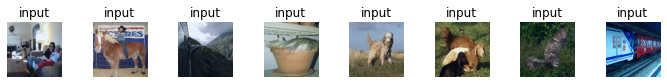

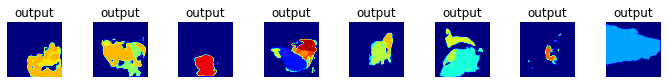

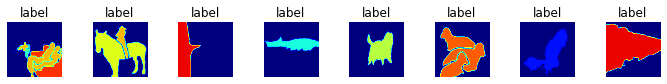

model saved to >> model_epoch100_200_KFold_1_2.pth
fold:1 epoch:101/200 [tra]loss:0.4221 acc:0.8743  [val]loss:1.0034 acc:0.0000  [time]total:16.64sec tra:12.02sec val:4.63sec
fold:1 epoch:102/200 [tra]loss:0.4471 acc:0.8667  [val]loss:1.0148 acc:0.0000  [time]total:16.74sec tra:12.03sec val:4.72sec
fold:1 epoch:103/200 [tra]loss:0.4196 acc:0.8744  [val]loss:0.9257 acc:0.0000  [time]total:16.69sec tra:12.04sec val:4.65sec
fold:1 epoch:104/200 [tra]loss:0.4054 acc:0.8787  [val]loss:1.0272 acc:0.0000  [time]total:16.84sec tra:12.12sec val:4.72sec
fold:1 epoch:105/200 [tra]loss:0.3967 acc:0.8798  [val]loss:1.0171 acc:0.0000  [time]total:16.68sec tra:12.02sec val:4.67sec
fold:1 epoch:106/200 [tra]loss:0.4238 acc:0.8745  [val]loss:1.0097 acc:0.0000  [time]total:16.73sec tra:12.03sec val:4.70sec
fold:1 epoch:107/200 [tra]loss:0.3790 acc:0.8865  [val]loss:0.9769 acc:0.0000  [time]total:16.65sec tra:12.03sec val:4.61sec
fold:1 epoch:108/200 [tra]loss:0.3823 acc:0.8867  [val]loss:1.0992 acc:0.0

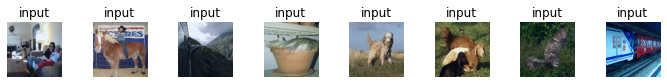

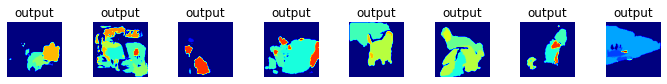

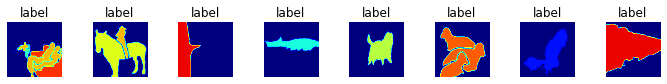

fold:1 epoch:151/200 [tra]loss:0.2488 acc:0.9241  [val]loss:1.1682 acc:0.0000  [time]total:16.81sec tra:12.05sec val:4.76sec
fold:1 epoch:152/200 [tra]loss:0.2103 acc:0.9353  [val]loss:1.1020 acc:0.0000  [time]total:16.94sec tra:12.28sec val:4.66sec
fold:1 epoch:153/200 [tra]loss:0.1954 acc:0.9412  [val]loss:1.1369 acc:0.0000  [time]total:16.66sec tra:12.01sec val:4.65sec
fold:1 epoch:154/200 [tra]loss:0.2008 acc:0.9378  [val]loss:1.1740 acc:0.0000  [time]total:16.69sec tra:11.99sec val:4.70sec
fold:1 epoch:155/200 [tra]loss:0.1947 acc:0.9411  [val]loss:1.1022 acc:0.0000  [time]total:16.74sec tra:12.05sec val:4.69sec
fold:1 epoch:156/200 [tra]loss:0.1934 acc:0.9411  [val]loss:1.0778 acc:0.0000  [time]total:16.64sec tra:12.00sec val:4.65sec
fold:1 epoch:157/200 [tra]loss:0.1959 acc:0.9402  [val]loss:1.1521 acc:0.0000  [time]total:16.64sec tra:12.00sec val:4.64sec
fold:1 epoch:158/200 [tra]loss:0.1746 acc:0.9469  [val]loss:1.1422 acc:0.0000  [time]total:16.69sec tra:12.06sec val:4.63sec


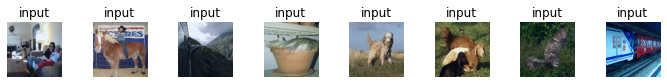

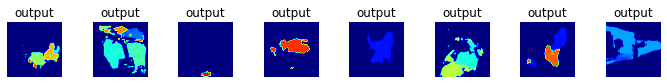

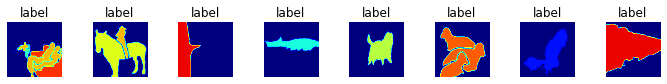

model saved to >> model_epoch200_200_KFold_1_2.pth
model saved to >> model_epoch200_KFold_1_2.pth



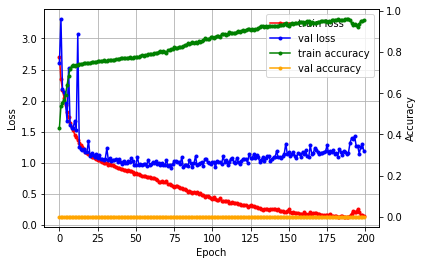

In [16]:
train_models, train_model_paths = train()

# Test

In [ ]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    ds = torchvision.datasets.VOCSegmentation(root="./", image_set="val", download=True)

    X_val = [np.array(x[0], dtype=np.float32) for x in ds]
    t_val = [np.array(x[1].convert('P')) for x in ds]

    dataset_val = VOCDataset(X_val, t_val, transforms=transforms_val)
    dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=4, shuffle=False, pin_memory=False)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            xs = batch[0].to(device) # image
            ts = batch[1].to(device) # target
        
            ys = model(xs)

            _ys = ys.permute(0, 2, 3, 1).reshape(-1, 22)
            _ts = ts.view(-1)
            
            _, predicted = torch.max(ys.data, 1)
            total += ys.size(0)
            correct += (predicted == ts).sum().item()

            show_sample(xs)
            show_sample_seg(ys)
            show_sample_label(ts)

            if step >= 1:
                break

test(train_models)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
